In [1]:
import numpy as np
import torch
import pyepo

# random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
num_node = 20 # node size
num_data = 100 # number of training data
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data+100+1000, num_feat, num_node, deg, e, seed=42)

In [3]:
from model import tspDFJModel
# set solver
optmodel = tspDFJModel(num_node)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
tour = optmodel.getTour(sol)
print(" -> ".join(map(str, tour)))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 58.2849
0 -> 5 -> 3 -> 17 -> 1 -> 12 -> 4 -> 18 -> 9 -> 16 -> 7 -> 2 -> 14 -> 6 -> 13 -> 11 -> 19 -> 8 -> 15 -> 10 -> 0


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 111.67it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 112.41it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 104.44it/s]


In [6]:
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, costs=c_train) # with binding constr

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 50.13it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
from dataset import collate_fn
batch_size = 32
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node-1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt
def plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-10, num_epochs+10)
    plt.ylim(0, 0.8)
    plt.xticks(range(0, num_epochs+1, 50), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
lr = 5e-2
num_epochs = 400
log_step = 20

In [11]:
import time
from tqdm import tqdm
from earlystop import earlyStopper

def pipeline(reg, forward_func, loss_func, lr, num_epochs, log_step, loader_train, loader_val, loader_test, seed=42):
    # set random seed
    np.random.seed(42)
    torch.manual_seed(42)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    # init log
    loss_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                       format(epoch, regret_trn*100, regret_val*100))
            # early stop
            if stopper.stop(regret_val):
                print()
                print("Early Stop!")
                break
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass)
            loss = forward_func(data, reg, loss_func)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # regret
    regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
    regret_log_trn.append(regret_trn)
    regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
    regret_log_val.append(regret_val)
    tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
               format(epoch, regret_trn*100, regret_val*100))
    print()
    print("Evaluation:")
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, regret_log_trn, regret_log_val

def forwardCAVE(data, reg, loss_func):
    # unzip data
    x, _, _, t_ctr = data
    # predict
    cp = reg(x)
    # loss
    loss = loss_func(cp, t_ctr)
    return loss

### 2-Stage 

In [12]:
# init model
reg = LinearRegression()

In [13]:
from torch import nn
# init loss
mse = nn.MSELoss()

def forward2S(data, reg, loss_func):
    # unzip data
    x, c, w, z = data
    # predict
    cp = reg(x)
    # loss
    loss = loss_func(cp, c)
    return loss

In [14]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forward2S, mse, lr, num_epochs, log_step,
                                                    loader_train_cost, loader_val, loader_test)

  0%|                                                                                          | 0/400 [00:02<?, ?it/s]

Epoch   0, Train Regret: 229.1573%, Val Regret: 226.7782%


Epoch   19, Loss:  16.8684:   5%|██▋                                                  | 20/400 [00:24<06:25,  1.01s/it]

Epoch  20, Train Regret:  22.2205%, Val Regret:  24.4857%


Epoch   39, Loss:  12.0736:  10%|█████▎                                               | 40/400 [00:46<06:05,  1.01s/it]

Epoch  40, Train Regret:  20.3812%, Val Regret:  20.9463%


Epoch   59, Loss:  17.6182:  15%|███████▉                                             | 60/400 [01:09<05:44,  1.01s/it]

Epoch  60, Train Regret:  17.4124%, Val Regret:  18.4560%


Epoch   79, Loss:  11.7675:  20%|██████████▌                                          | 80/400 [01:31<05:24,  1.01s/it]

Epoch  80, Train Regret:  16.2709%, Val Regret:  16.4961%


Epoch   99, Loss:   6.9176:  25%|█████████████                                       | 100/400 [01:54<05:04,  1.01s/it]

Epoch 100, Train Regret:  15.8802%, Val Regret:  17.2513%


Epoch  119, Loss:   6.7721:  30%|███████████████▌                                    | 120/400 [02:16<04:43,  1.01s/it]

Epoch 120, Train Regret:  16.3900%, Val Regret:  16.9215%


Epoch  139, Loss:   6.2329:  35%|██████████████████▏                                 | 140/400 [02:39<04:23,  1.01s/it]

Epoch 140, Train Regret:  15.3825%, Val Regret:  16.2233%


Epoch  159, Loss:  16.3241:  40%|████████████████████▊                               | 160/400 [03:01<04:03,  1.01s/it]

Epoch 160, Train Regret:  14.9757%, Val Regret:  16.5433%


Epoch  179, Loss:   6.1063:  45%|███████████████████████▍                            | 180/400 [03:24<03:43,  1.01s/it]

Epoch 180, Train Regret:  15.4667%, Val Regret:  16.9749%


Epoch  199, Loss:   4.2576:  50%|██████████████████████████                          | 200/400 [03:46<03:46,  1.13s/it]


Epoch 200, Train Regret:  15.1048%, Val Regret:  16.4125%

Early Stop!
Epoch 200, Train Regret:  15.1048%, Val Regret:  16.4125%

Evaluation:
Test Regret: 16.4118%
Training Elapsed Time: 2.37 Sec


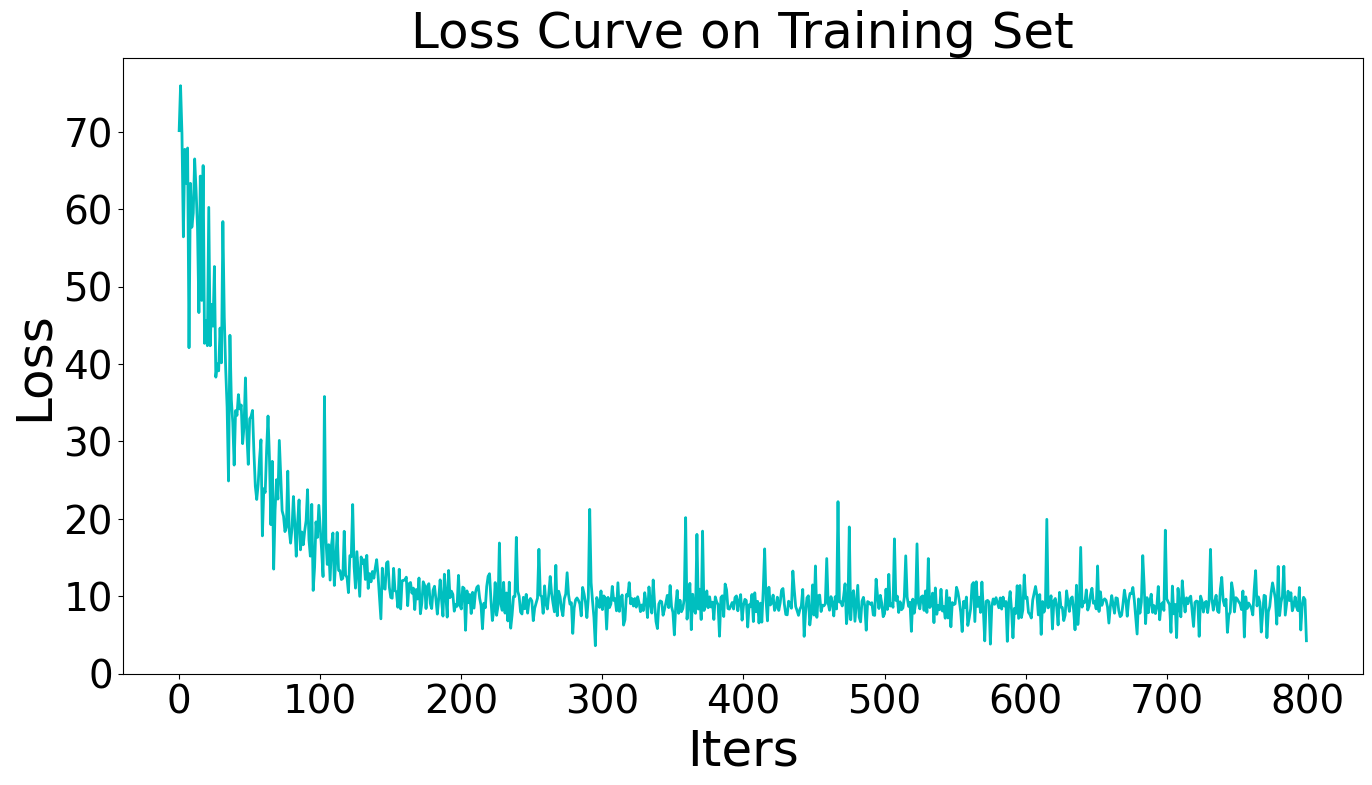

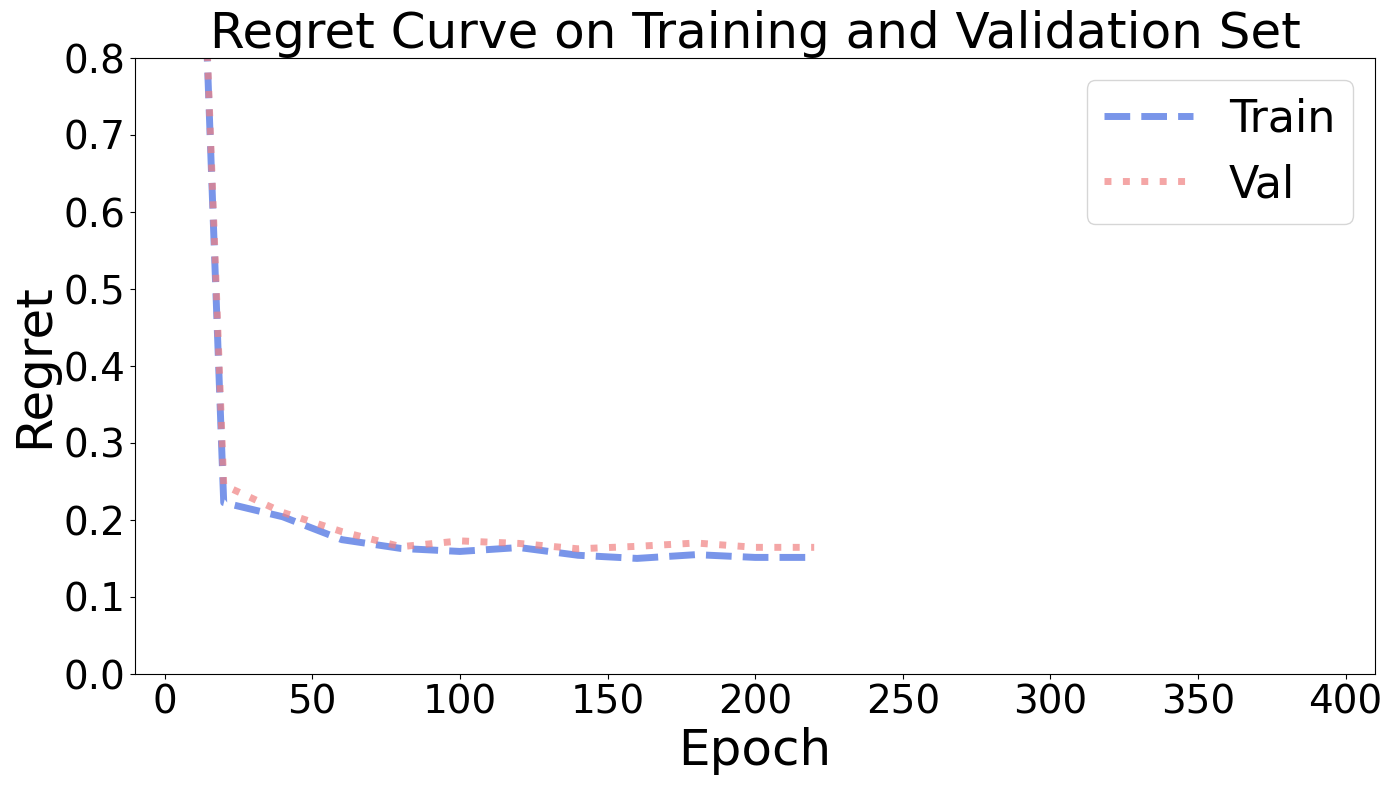

In [15]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Exact Method with Clarabel

In [16]:
# init model
reg = LinearRegression()

In [17]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="clarabel", processes=8)

(CVXPY) Nov 22 09:47:13 AM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')
Num of cores: 8


In [18]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/400 [00:02<?, ?it/s]

Epoch   0, Train Regret: 197.6313%, Val Regret: 198.0874%


Epoch   19, Loss:  -0.9999:   5%|██▋                                                  | 20/400 [00:34<07:50,  1.24s/it]

Epoch  20, Train Regret:   9.8615%, Val Regret:  29.3859%


Epoch   39, Loss:  -1.0000:  10%|█████▎                                               | 40/400 [01:01<07:25,  1.24s/it]

Epoch  40, Train Regret:   6.2101%, Val Regret:  28.8716%


Epoch   59, Loss:  -1.0000:  15%|███████▉                                             | 60/400 [01:28<07:06,  1.25s/it]

Epoch  60, Train Regret:   4.2323%, Val Regret:  28.5962%


Epoch   79, Loss:  -1.0000:  20%|██████████▌                                          | 80/400 [01:55<06:37,  1.24s/it]

Epoch  80, Train Regret:   1.8757%, Val Regret:  28.7841%


Epoch   99, Loss:  -1.0000:  25%|█████████████                                       | 100/400 [02:22<06:13,  1.25s/it]

Epoch 100, Train Regret:   0.1234%, Val Regret:  28.7841%


Epoch  119, Loss:  -1.0000:  30%|███████████████▌                                    | 120/400 [02:49<06:36,  1.42s/it]


Epoch 120, Train Regret:   0.0000%, Val Regret:  28.7841%

Early Stop!
Epoch 120, Train Regret:   0.0000%, Val Regret:  28.7841%

Evaluation:
Test Regret: 25.3622%
Training Elapsed Time: 34.31 Sec


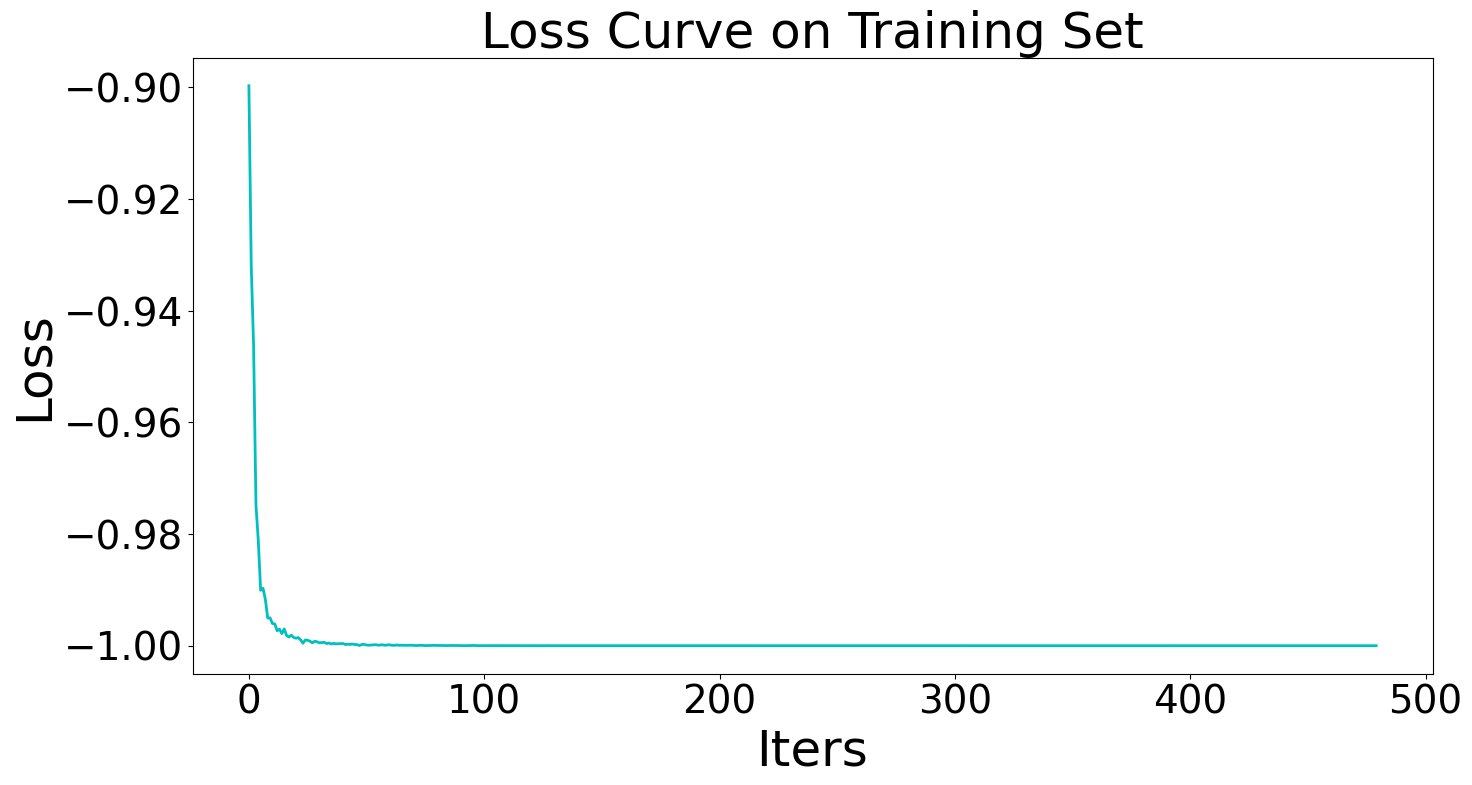

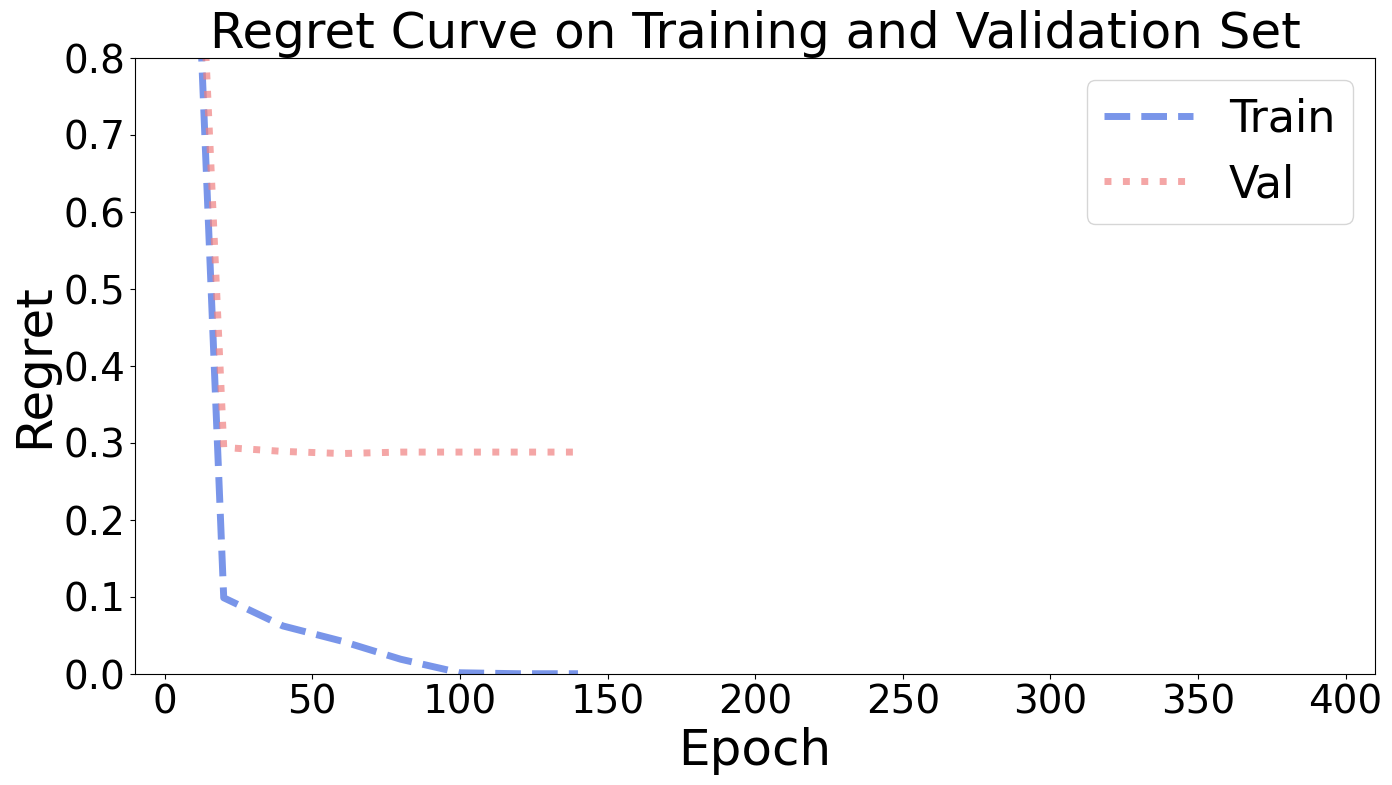

In [19]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Exact Method with NNLS

In [20]:
# init model
reg = LinearRegression()

In [21]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="nnls", processes=8)

Num of cores: 8


In [22]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/400 [00:02<?, ?it/s]

Epoch   0, Train Regret: 193.5132%, Val Regret: 196.8861%


Epoch   19, Loss:  -1.0000:   5%|██▋                                                  | 20/400 [00:30<08:13,  1.30s/it]

Epoch  20, Train Regret:  10.9692%, Val Regret:  30.1865%


Epoch   39, Loss:  -1.0000:  10%|█████▎                                               | 40/400 [00:58<07:42,  1.29s/it]

Epoch  40, Train Regret:   7.8414%, Val Regret:  28.7161%


Epoch   59, Loss:  -1.0000:  15%|███████▉                                             | 60/400 [01:26<07:15,  1.28s/it]

Epoch  60, Train Regret:   5.8545%, Val Regret:  27.7082%


Epoch   79, Loss:  -1.0000:  20%|██████████▌                                          | 80/400 [01:54<06:49,  1.28s/it]

Epoch  80, Train Regret:   4.4408%, Val Regret:  27.4544%


Epoch   99, Loss:  -1.0000:  25%|█████████████                                       | 100/400 [02:22<06:28,  1.29s/it]

Epoch 100, Train Regret:   0.9485%, Val Regret:  27.7066%


Epoch  119, Loss:  -1.0000:  30%|███████████████▌                                    | 120/400 [02:50<05:58,  1.28s/it]

Epoch 120, Train Regret:   0.0000%, Val Regret:  27.7066%


Epoch  139, Loss:  -1.0000:  35%|██████████████████▏                                 | 140/400 [03:17<06:07,  1.41s/it]


Epoch 140, Train Regret:   0.0000%, Val Regret:  27.7066%

Early Stop!
Epoch 140, Train Regret:   0.0000%, Val Regret:  27.7066%

Evaluation:
Test Regret: 28.8059%
Training Elapsed Time: 40.04 Sec


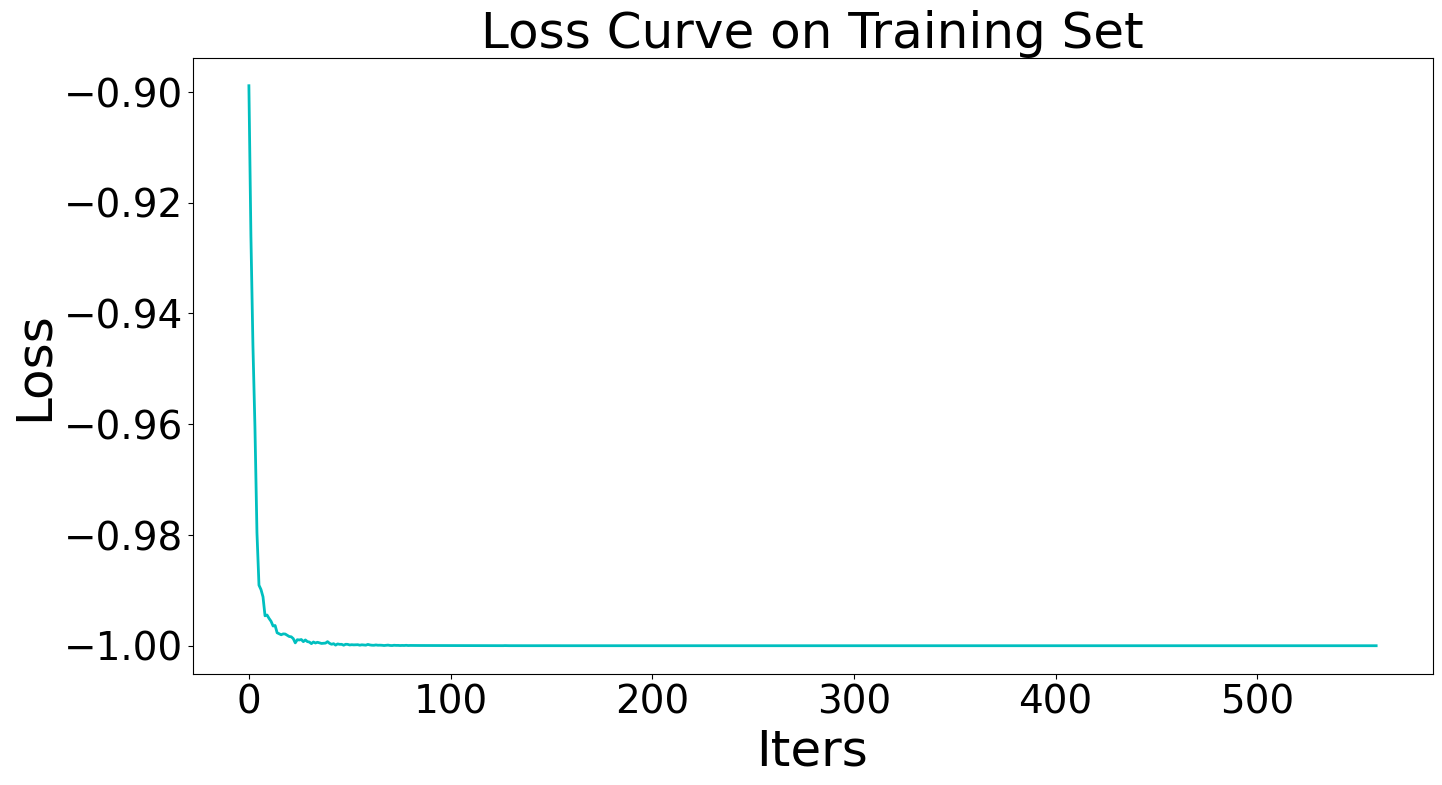

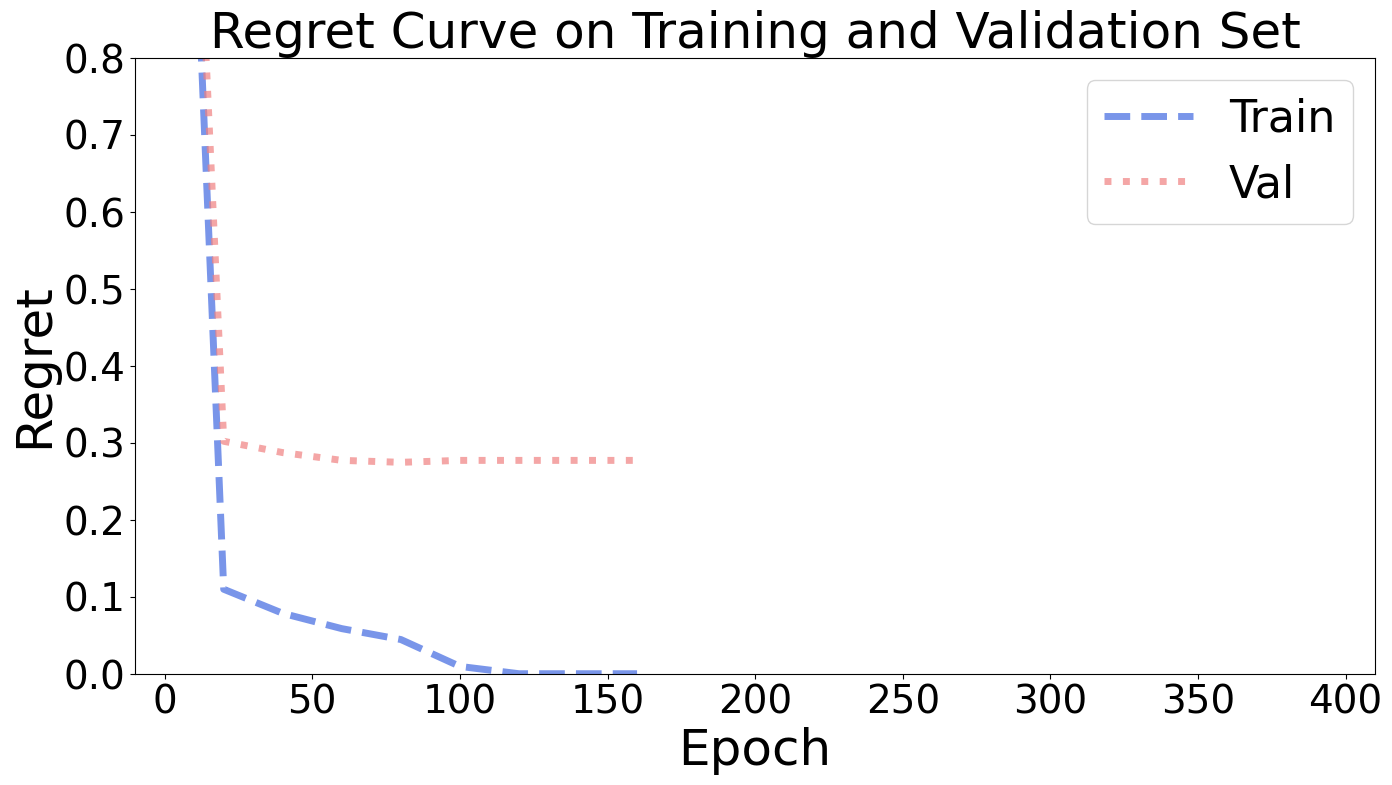

In [23]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method

In [24]:
# init model
reg = LinearRegression()

In [25]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100)

In [26]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/400 [00:02<?, ?it/s]

Epoch   0, Train Regret: 210.9560%, Val Regret: 204.8857%


Epoch   19, Loss:  -0.7632:   5%|██▋                                                  | 20/400 [00:25<06:54,  1.09s/it]

Epoch  20, Train Regret:  16.2570%, Val Regret:  26.2442%


Epoch   39, Loss:  -0.7714:  10%|█████▎                                               | 40/400 [00:50<06:32,  1.09s/it]

Epoch  40, Train Regret:  15.5524%, Val Regret:  23.6610%


Epoch   59, Loss:  -0.7651:  15%|███████▉                                             | 60/400 [01:14<06:10,  1.09s/it]

Epoch  60, Train Regret:  14.9758%, Val Regret:  24.2342%


Epoch   79, Loss:  -0.7579:  20%|██████████▌                                          | 80/400 [01:38<05:48,  1.09s/it]

Epoch  80, Train Regret:  15.8293%, Val Regret:  24.6970%


Epoch   99, Loss:  -0.7965:  25%|█████████████                                       | 100/400 [02:02<05:26,  1.09s/it]

Epoch 100, Train Regret:  14.7642%, Val Regret:  23.0685%


Epoch  119, Loss:  -0.7558:  30%|███████████████▌                                    | 120/400 [02:26<05:05,  1.09s/it]

Epoch 120, Train Regret:  14.1291%, Val Regret:  22.9332%


Epoch  139, Loss:  -0.8046:  35%|██████████████████▏                                 | 140/400 [02:50<04:43,  1.09s/it]

Epoch 140, Train Regret:  14.5917%, Val Regret:  24.9483%


Epoch  159, Loss:  -0.7874:  40%|████████████████████▊                               | 160/400 [03:14<04:21,  1.09s/it]

Epoch 160, Train Regret:  13.1175%, Val Regret:  24.2470%


Epoch  179, Loss:  -0.7705:  45%|███████████████████████▍                            | 180/400 [03:38<03:59,  1.09s/it]

Epoch 180, Train Regret:  14.2714%, Val Regret:  22.4091%


Epoch  199, Loss:  -0.8161:  50%|██████████████████████████                          | 200/400 [04:02<03:37,  1.09s/it]

Epoch 200, Train Regret:  14.0245%, Val Regret:  23.6682%


Epoch  219, Loss:  -0.7982:  55%|████████████████████████████▌                       | 220/400 [04:26<03:16,  1.09s/it]

Epoch 220, Train Regret:  12.9950%, Val Regret:  22.2067%


Epoch  239, Loss:  -0.7986:  60%|███████████████████████████████▏                    | 240/400 [04:50<02:54,  1.09s/it]

Epoch 240, Train Regret:  14.5351%, Val Regret:  24.3466%


Epoch  259, Loss:  -0.8060:  65%|█████████████████████████████████▊                  | 260/400 [05:14<02:32,  1.09s/it]

Epoch 260, Train Regret:  13.6517%, Val Regret:  24.0060%


Epoch  279, Loss:  -0.8022:  70%|████████████████████████████████████▍               | 280/400 [05:38<02:25,  1.21s/it]


Epoch 280, Train Regret:  14.3661%, Val Regret:  22.7024%

Early Stop!
Epoch 280, Train Regret:  14.3661%, Val Regret:  22.7024%

Evaluation:
Test Regret: 22.9759%
Training Elapsed Time: 24.48 Sec


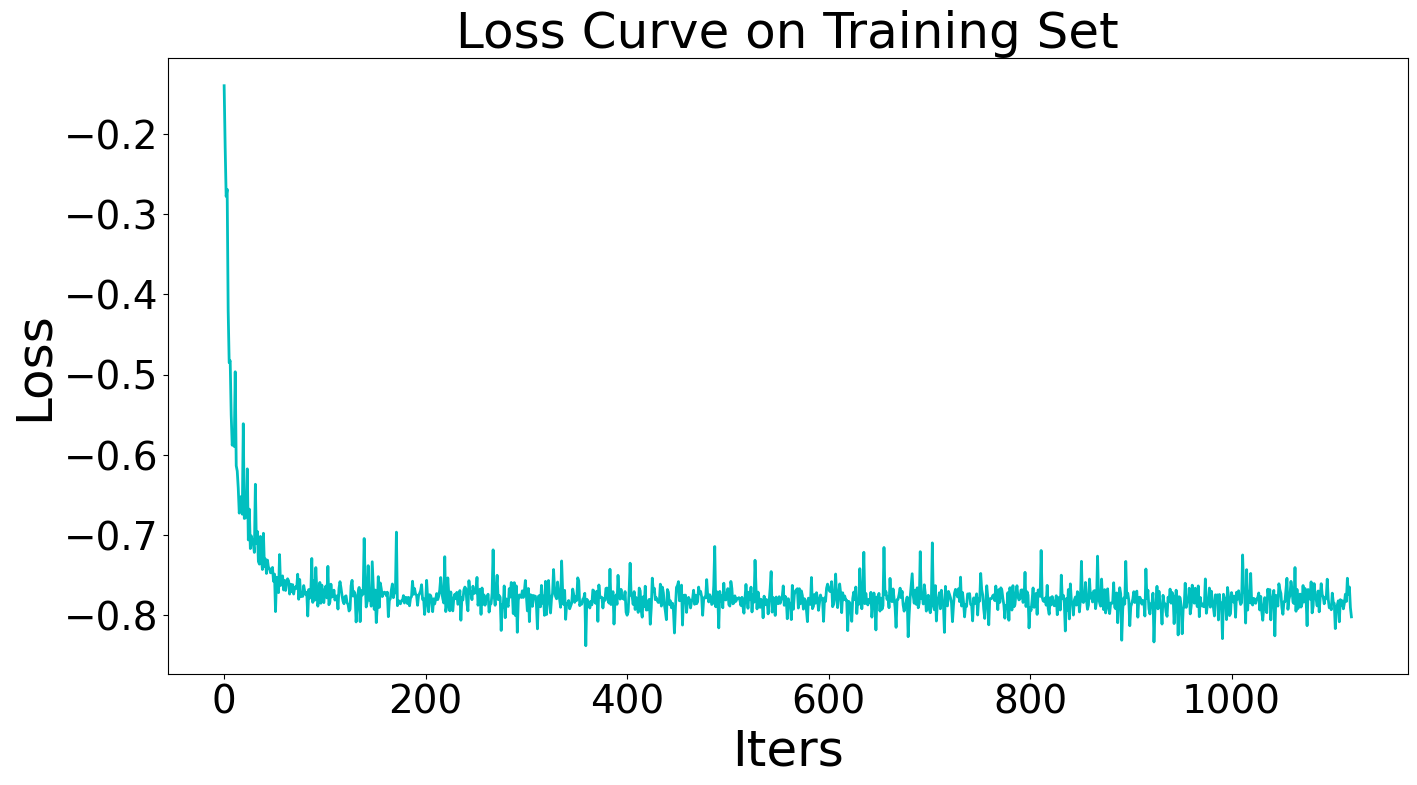

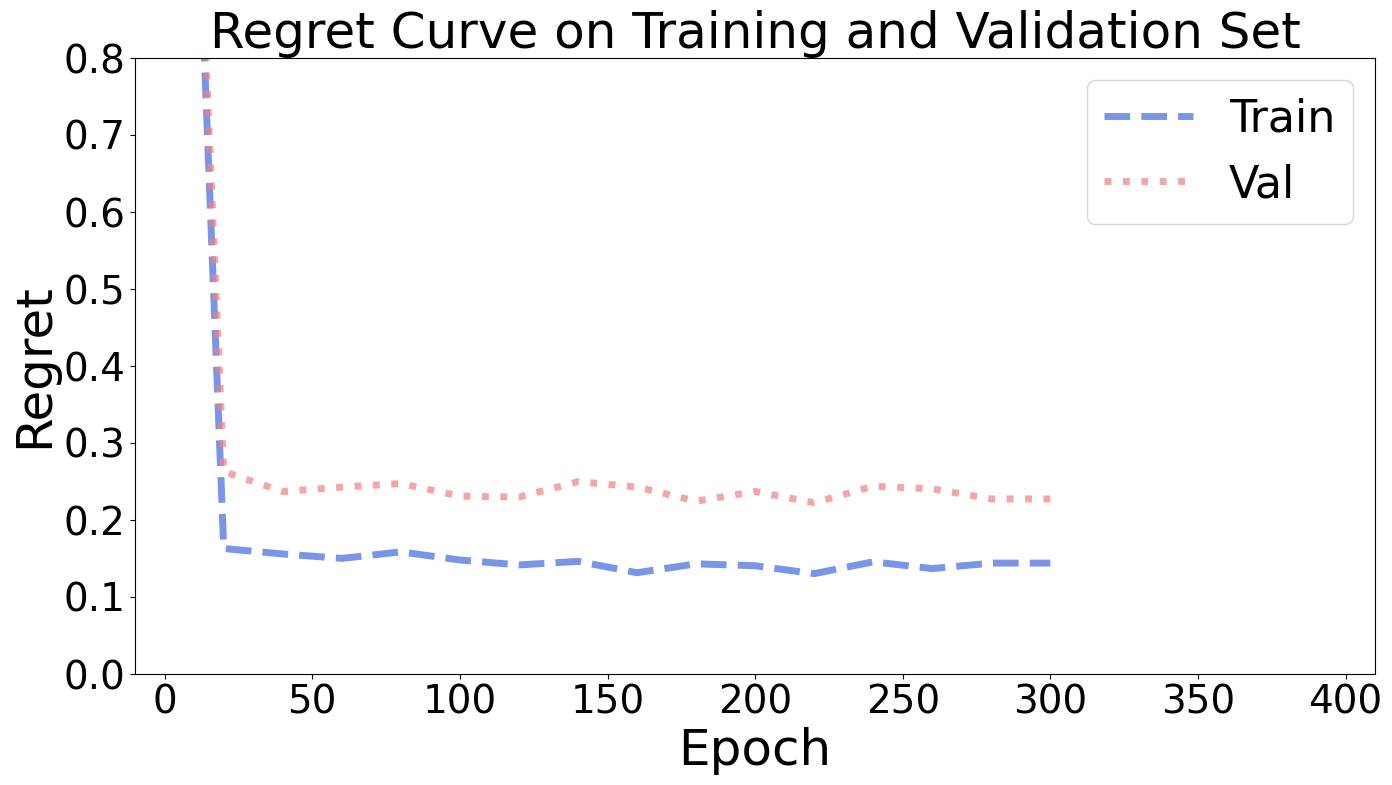

In [27]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Average Method

In [28]:
# init model
reg = LinearRegression()

In [29]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel)

In [30]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/400 [00:02<?, ?it/s]

Epoch   0, Train Regret: 185.7996%, Val Regret: 185.0819%


Epoch   19, Loss:  -0.7100:   5%|██▋                                                  | 20/400 [00:24<06:29,  1.02s/it]

Epoch  20, Train Regret:  13.3591%, Val Regret:  22.6332%


Epoch   39, Loss:  -0.8000:  10%|█████▎                                               | 40/400 [00:47<06:08,  1.02s/it]

Epoch  40, Train Regret:  15.6075%, Val Regret:  22.9291%


Epoch   59, Loss:  -0.7820:  15%|███████▉                                             | 60/400 [01:10<05:48,  1.03s/it]

Epoch  60, Train Regret:  14.6856%, Val Regret:  24.3396%


Epoch   79, Loss:  -0.6920:  20%|██████████▌                                          | 80/400 [01:33<06:12,  1.16s/it]


Epoch  80, Train Regret:  13.6570%, Val Regret:  24.0295%

Early Stop!
Epoch  80, Train Regret:  13.6570%, Val Regret:  24.0295%

Evaluation:
Test Regret: 22.9932%
Training Elapsed Time: 1.83 Sec


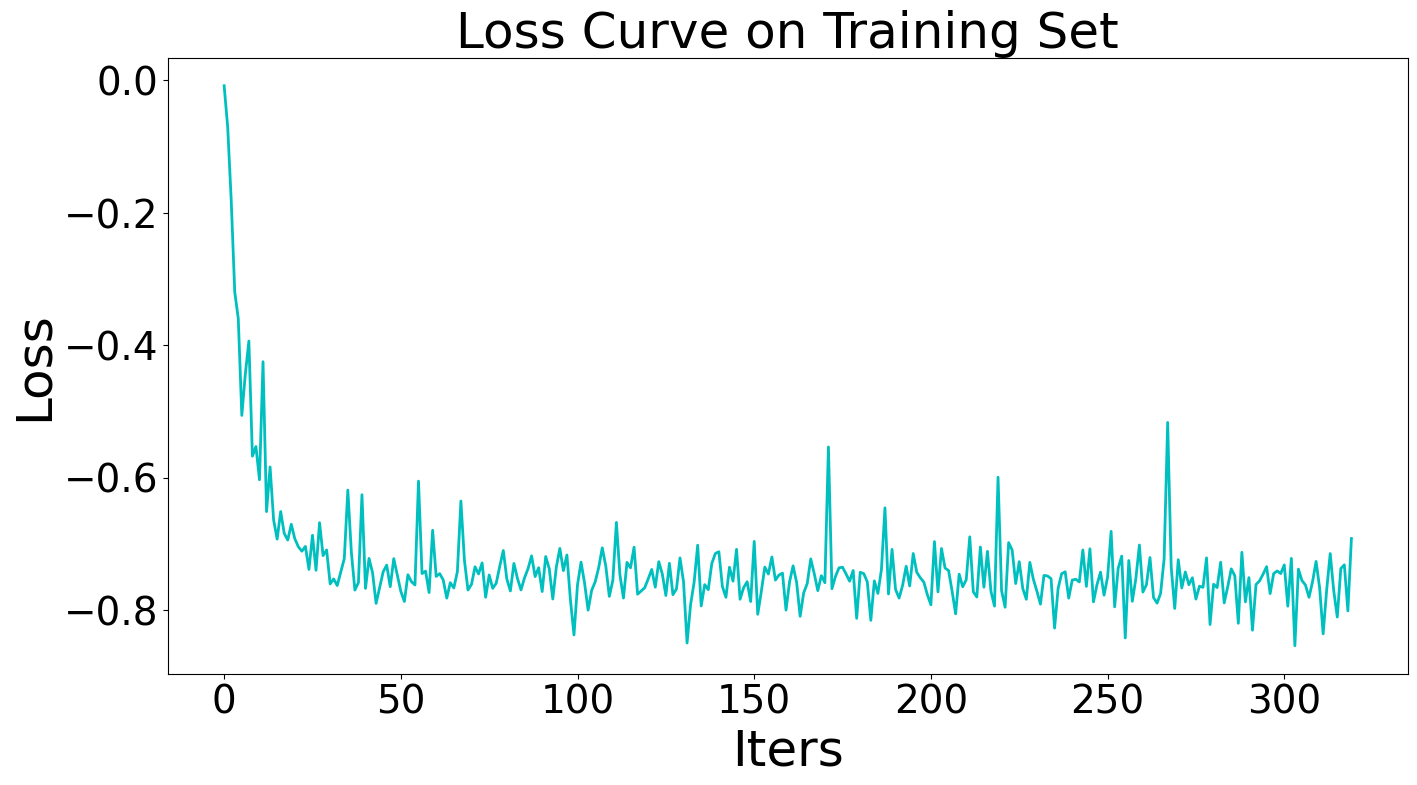

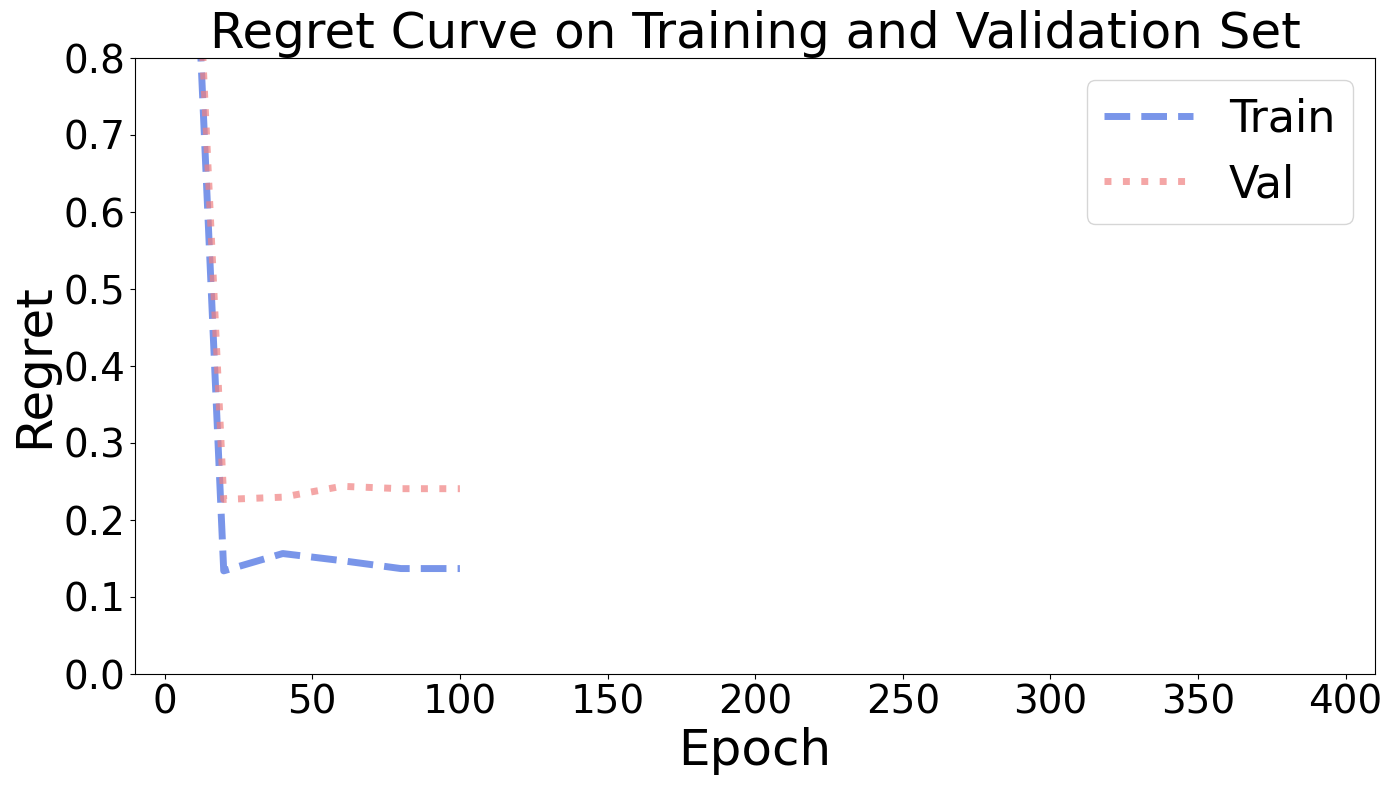

In [31]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sign Method 

In [32]:
# init model
reg = LinearRegression()

In [33]:
from func import signConeAlignedCosine
# init loss
ca_cos = signConeAlignedCosine(optmodel)

In [34]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/400 [00:02<?, ?it/s]

Epoch   0, Train Regret: 219.9754%, Val Regret: 210.3004%


Epoch   19, Loss:  -0.9983:   5%|██▋                                                  | 20/400 [00:24<06:29,  1.02s/it]

Epoch  20, Train Regret:  16.2762%, Val Regret:  35.9502%


Epoch   39, Loss:  -0.9995:  10%|█████▎                                               | 40/400 [00:47<06:09,  1.03s/it]

Epoch  40, Train Regret:  14.4068%, Val Regret:  34.2174%


Epoch   59, Loss:  -0.9995:  15%|███████▉                                             | 60/400 [01:10<05:48,  1.03s/it]

Epoch  60, Train Regret:  15.9083%, Val Regret:  35.9688%


Epoch   79, Loss:  -0.9997:  20%|██████████▌                                          | 80/400 [01:32<05:28,  1.03s/it]

Epoch  80, Train Regret:  15.8579%, Val Regret:  37.4249%


Epoch   99, Loss:  -0.9995:  25%|█████████████                                       | 100/400 [01:55<05:46,  1.15s/it]


Epoch 100, Train Regret:  15.1807%, Val Regret:  39.6921%

Early Stop!
Epoch 100, Train Regret:  15.1807%, Val Regret:  39.6921%

Evaluation:
Test Regret: 35.0192%
Training Elapsed Time: 2.33 Sec


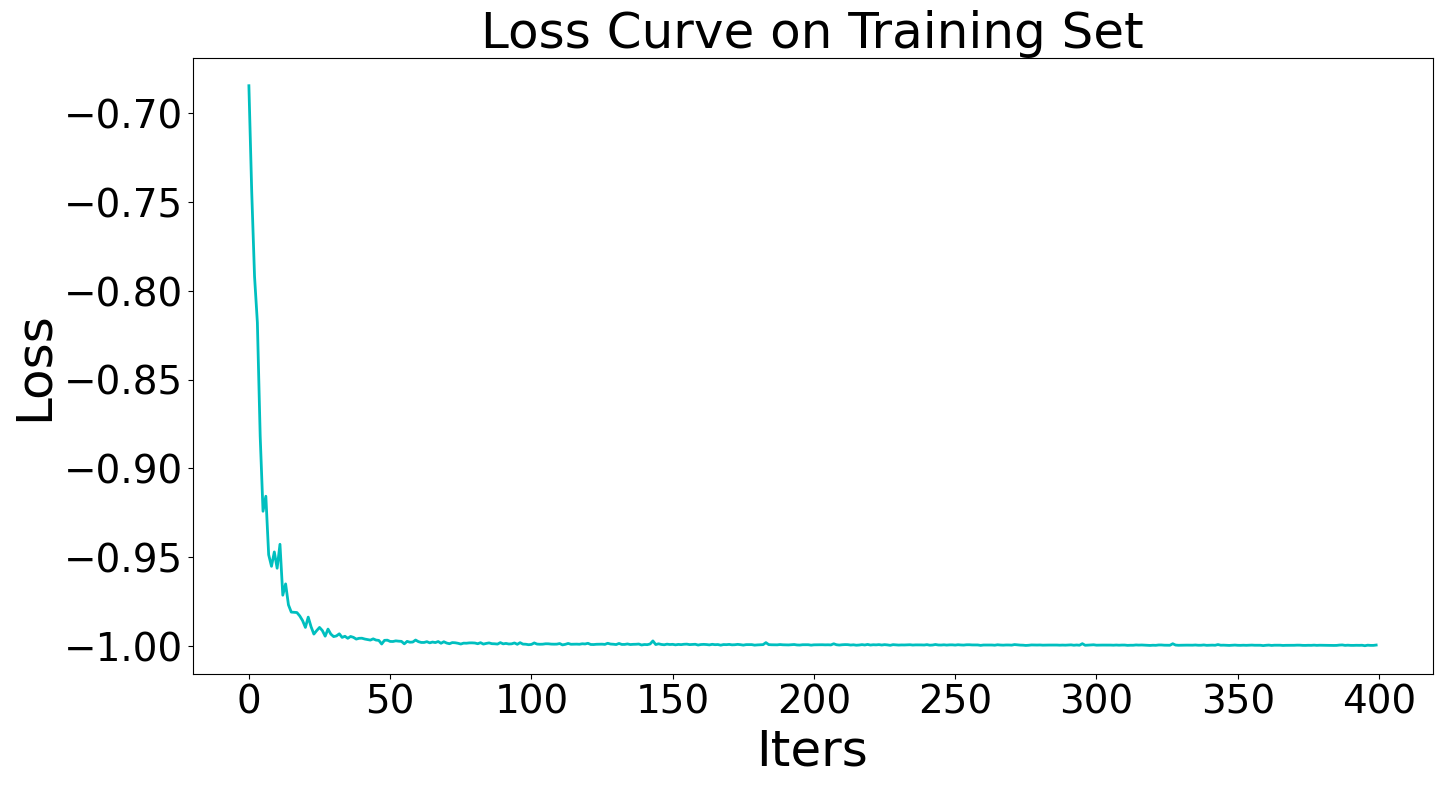

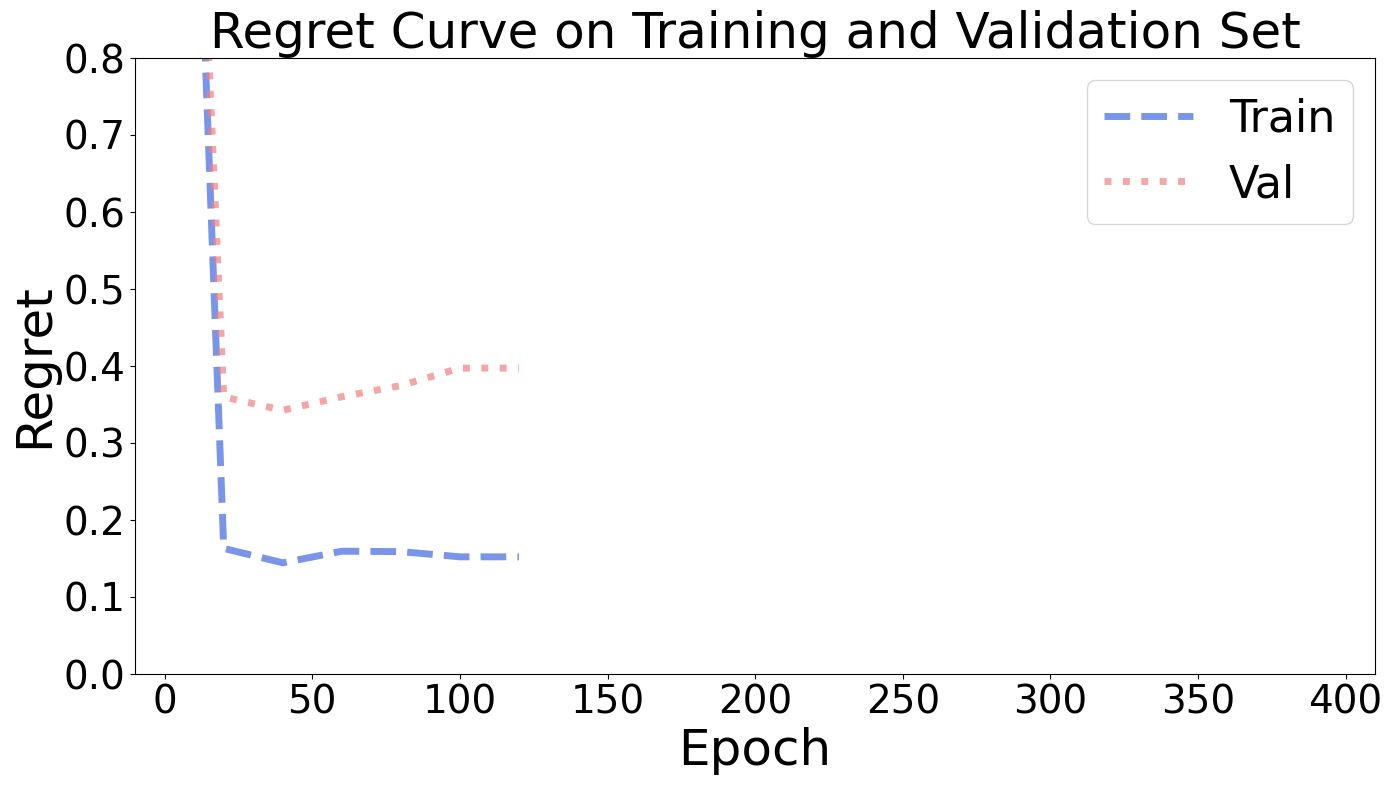

In [35]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### PFYL 

In [36]:
# init model
reg = LinearRegression()

In [37]:
from pyepo.func import perturbedFenchelYoung
# init pfyl loss
pfy = perturbedFenchelYoung(optmodel, n_samples=1, sigma=1.0, processes=8)

def forwardPFY(data, reg, loss_func):
    # unzip data
    x, _, w, _ = data
    # predict
    cp = reg(x)
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 8


In [38]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardPFY, pfy, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/400 [00:02<?, ?it/s]

Epoch   0, Train Regret: 197.9496%, Val Regret: 193.2480%


Epoch   19, Loss:  15.0000:   5%|██▋                                                  | 20/400 [00:31<08:36,  1.36s/it]

Epoch  20, Train Regret:   6.2537%, Val Regret:  18.5681%


Epoch   39, Loss:   7.5000:  10%|█████▎                                               | 40/400 [01:00<08:04,  1.35s/it]

Epoch  40, Train Regret:   5.1892%, Val Regret:  18.9275%


Epoch   59, Loss:  13.5000:  15%|███████▉                                             | 60/400 [01:30<07:42,  1.36s/it]

Epoch  60, Train Regret:   3.0708%, Val Regret:  18.1551%


Epoch   79, Loss:   6.5000:  20%|██████████▌                                          | 80/400 [01:59<07:09,  1.34s/it]

Epoch  80, Train Regret:   2.0208%, Val Regret:  17.5406%


Epoch   99, Loss:   8.0000:  25%|█████████████                                       | 100/400 [02:28<06:43,  1.35s/it]

Epoch 100, Train Regret:   1.9954%, Val Regret:  16.4442%


Epoch  119, Loss:   4.0000:  30%|███████████████▌                                    | 120/400 [02:58<06:15,  1.34s/it]

Epoch 120, Train Regret:   1.5716%, Val Regret:  16.9209%


Epoch  139, Loss:  12.5000:  35%|██████████████████▏                                 | 140/400 [03:27<05:51,  1.35s/it]

Epoch 140, Train Regret:   1.3496%, Val Regret:  18.0670%


Epoch  159, Loss:   4.5000:  40%|████████████████████▊                               | 160/400 [03:56<05:54,  1.48s/it]


Epoch 160, Train Regret:   1.0428%, Val Regret:  16.6257%

Early Stop!
Epoch 160, Train Regret:   1.0428%, Val Regret:  16.6257%

Evaluation:
Test Regret: 17.2518%
Training Elapsed Time: 56.56 Sec


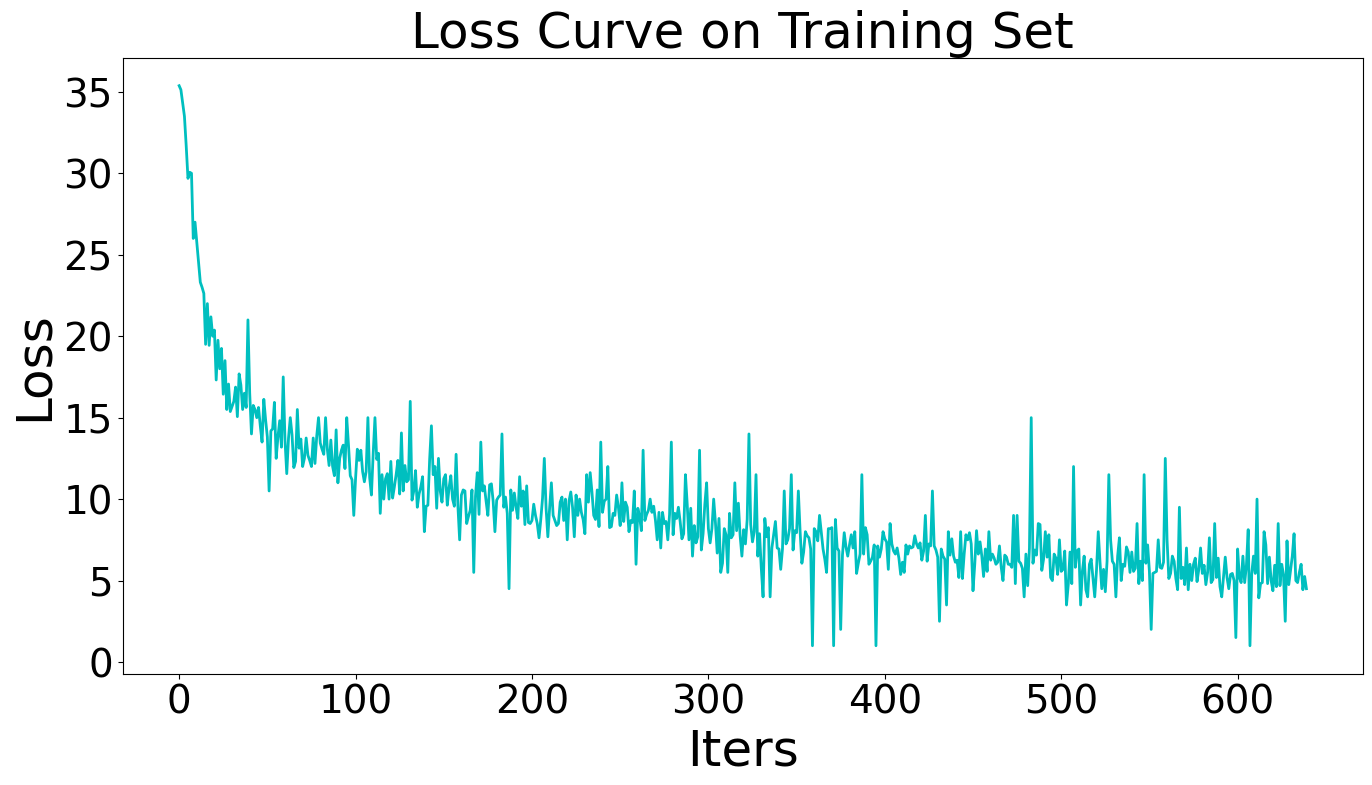

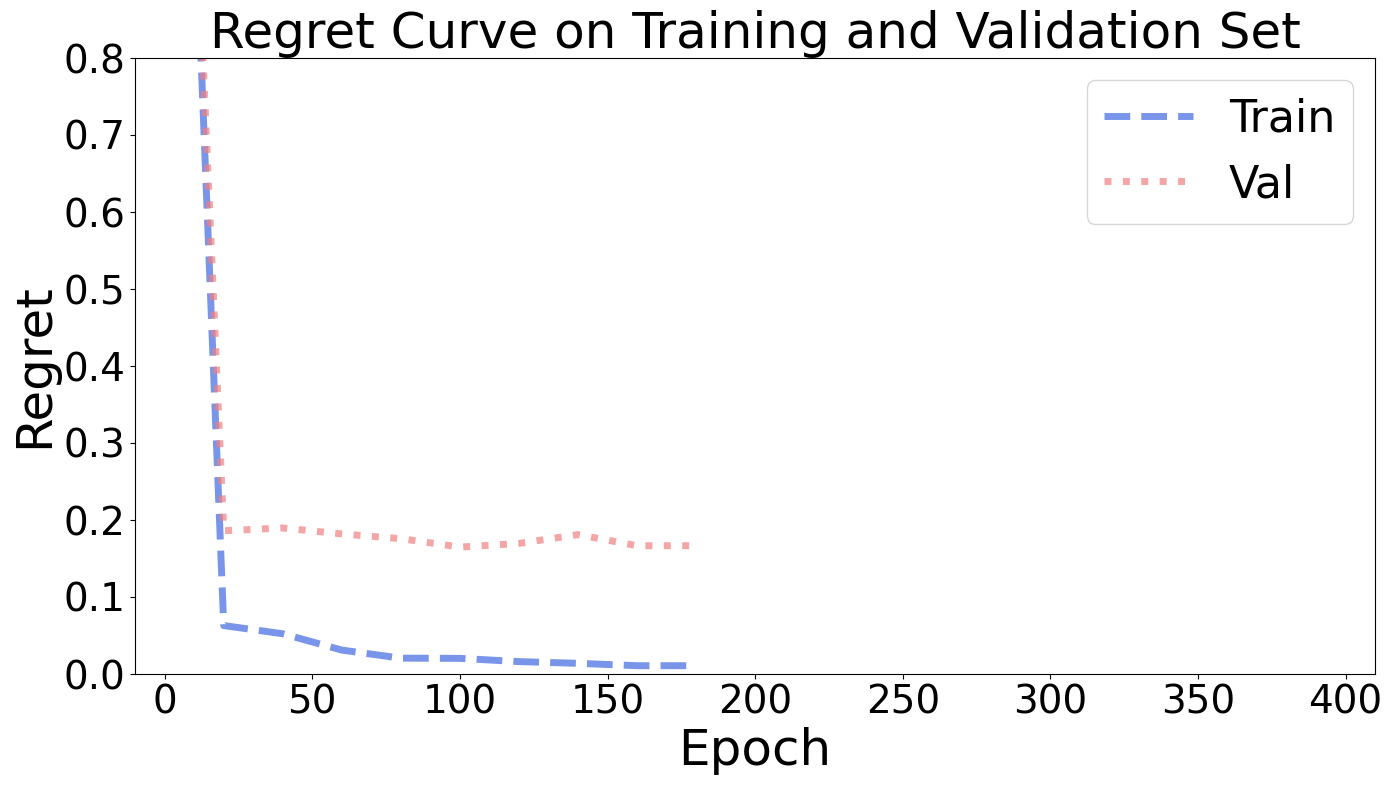

In [39]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### NCE 

In [40]:
# init model
reg = LinearRegression()

In [41]:
from pyepo.func import NCE
# init nce loss
nce = NCE(optmodel, processes=8, solve_ratio=0.05, dataset=dataset_train_cost)

def forwardNCE(data, reg, loss_func):
    # unzip data
    x, _, w, _ = data
    # predict
    cp = reg(x)
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 8


In [42]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardNCE, nce, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/400 [00:02<?, ?it/s]

Epoch   0, Train Regret: 218.4324%, Val Regret: 212.4588%


Epoch   19, Loss: -205.4427:   5%|██▌                                                 | 20/400 [00:25<06:39,  1.05s/it]

Epoch  20, Train Regret:  20.0533%, Val Regret:  31.5101%


Epoch   39, Loss: -349.7183:  10%|█████▏                                              | 40/400 [00:48<06:14,  1.04s/it]

Epoch  40, Train Regret:  17.9245%, Val Regret:  28.9882%


Epoch   59, Loss: -511.1686:  15%|███████▊                                            | 60/400 [01:11<06:00,  1.06s/it]

Epoch  60, Train Regret:  16.0481%, Val Regret:  28.9926%


Epoch   79, Loss: -861.2859:  20%|██████████▍                                         | 80/400 [01:34<05:36,  1.05s/it]

Epoch  80, Train Regret:  15.3922%, Val Regret:  29.0581%


Epoch   99, Loss: -743.7830:  25%|████████████▊                                      | 100/400 [01:57<05:10,  1.03s/it]

Epoch 100, Train Regret:  14.5410%, Val Regret:  28.5859%


Epoch  119, Loss: -973.6080:  30%|███████████████▎                                   | 120/400 [02:20<04:58,  1.06s/it]

Epoch 120, Train Regret:  14.8504%, Val Regret:  27.3913%


Epoch  139, Loss: -907.6412:  35%|█████████████████▊                                 | 140/400 [02:43<04:34,  1.05s/it]

Epoch 140, Train Regret:  15.2433%, Val Regret:  27.3941%


Epoch  159, Loss: -1738.2266:  40%|████████████████████                              | 160/400 [03:06<04:10,  1.04s/it]

Epoch 160, Train Regret:  14.8275%, Val Regret:  27.0608%


Epoch  179, Loss: -1458.2714:  45%|██████████████████████▌                           | 180/400 [03:29<03:45,  1.03s/it]

Epoch 180, Train Regret:  15.1951%, Val Regret:  26.7741%


Epoch  199, Loss: -1390.9449:  50%|█████████████████████████                         | 200/400 [03:52<03:30,  1.05s/it]

Epoch 200, Train Regret:  15.0857%, Val Regret:  26.5982%


Epoch  219, Loss: -1852.6223:  55%|███████████████████████████▌                      | 220/400 [04:15<03:15,  1.09s/it]

Epoch 220, Train Regret:  15.2001%, Val Regret:  26.8349%


Epoch  239, Loss: -1728.1549:  60%|██████████████████████████████                    | 240/400 [04:39<02:51,  1.07s/it]

Epoch 240, Train Regret:  14.5881%, Val Regret:  26.8601%


Epoch  259, Loss: -2905.1316:  65%|████████████████████████████████▌                 | 260/400 [05:02<02:26,  1.05s/it]

Epoch 260, Train Regret:  14.2978%, Val Regret:  26.3941%


Epoch  279, Loss: -2314.1895:  70%|███████████████████████████████████               | 280/400 [05:25<02:03,  1.03s/it]

Epoch 280, Train Regret:  13.7800%, Val Regret:  26.3370%


Epoch  299, Loss: -2985.7441:  75%|█████████████████████████████████████▌            | 300/400 [05:48<01:44,  1.05s/it]

Epoch 300, Train Regret:  13.9832%, Val Regret:  26.2568%


Epoch  319, Loss: -2911.7480:  80%|████████████████████████████████████████          | 320/400 [06:11<01:24,  1.06s/it]

Epoch 320, Train Regret:  14.3402%, Val Regret:  26.3899%


Epoch  339, Loss: -1963.8558:  85%|██████████████████████████████████████████▌       | 340/400 [06:34<01:02,  1.04s/it]

Epoch 340, Train Regret:  14.1940%, Val Regret:  26.2353%


Epoch  359, Loss: -3367.5825:  90%|█████████████████████████████████████████████     | 360/400 [06:58<00:42,  1.06s/it]

Epoch 360, Train Regret:  14.2229%, Val Regret:  26.3806%


Epoch  379, Loss: -2797.1753:  95%|███████████████████████████████████████████████▌  | 380/400 [07:21<00:21,  1.06s/it]

Epoch 380, Train Regret:  13.8818%, Val Regret:  26.4661%


Epoch  399, Loss: -3796.8057: 100%|██████████████████████████████████████████████████| 400/400 [07:42<00:00,  1.16s/it]


Epoch 399, Train Regret:  14.6548%, Val Regret:  26.5876%

Evaluation:
Test Regret: 28.8805%
Training Elapsed Time: 17.09 Sec


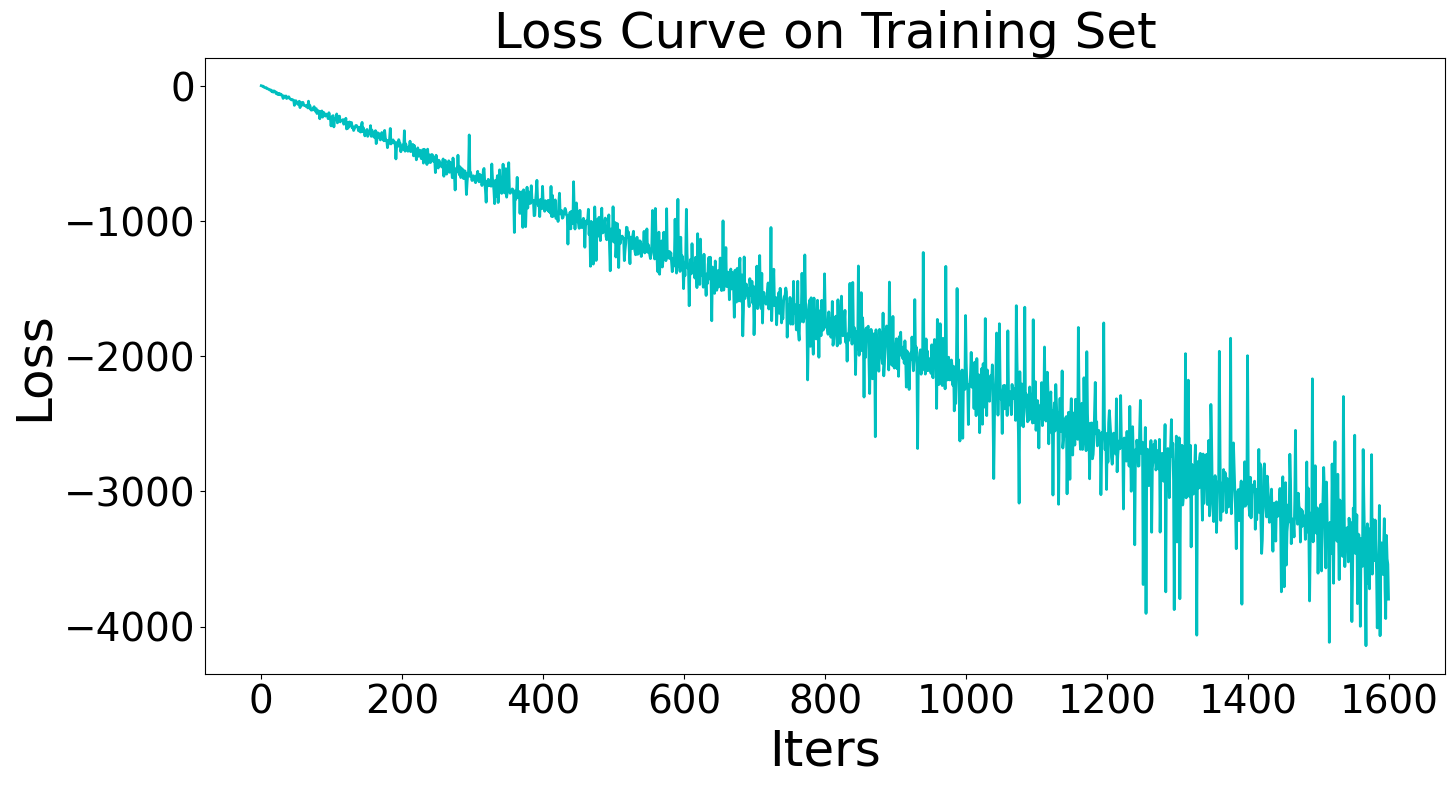

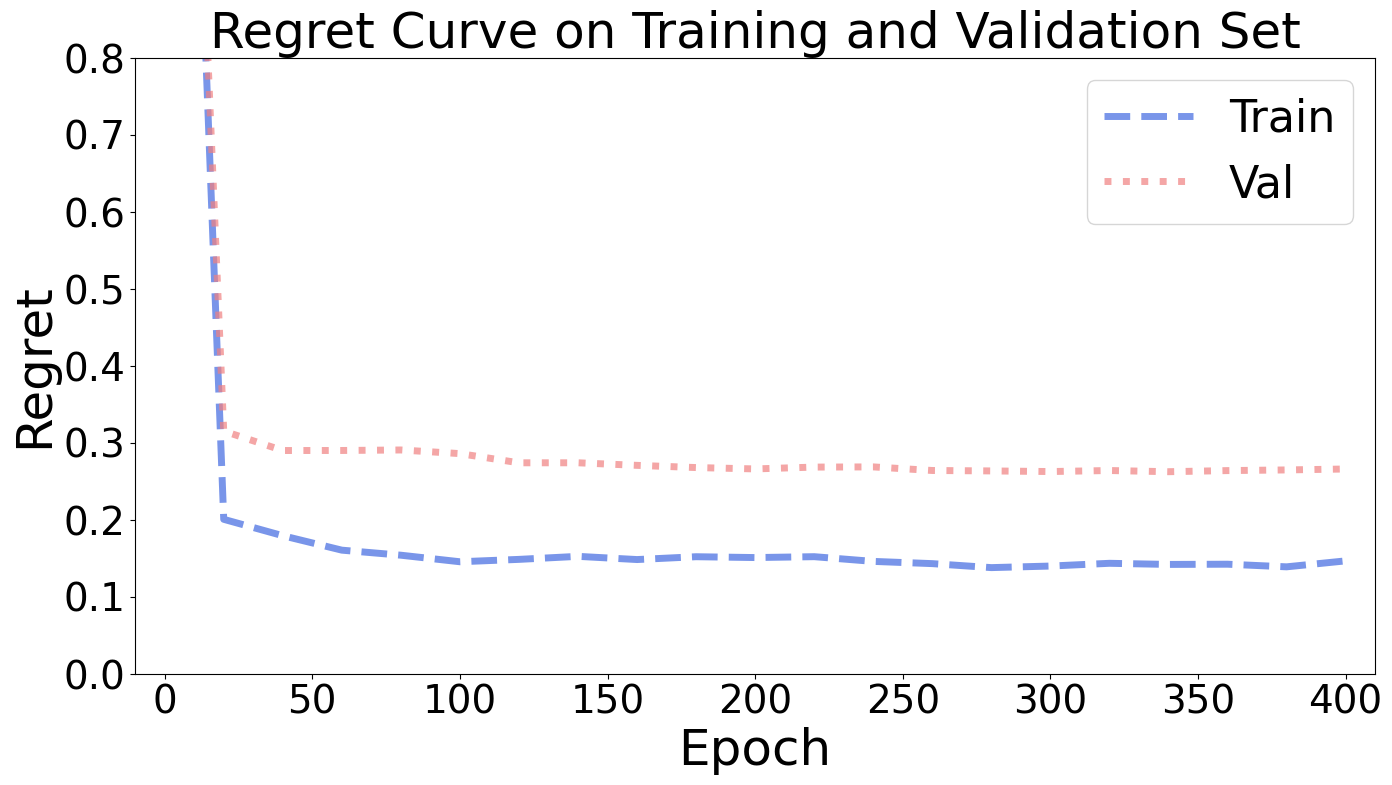

In [43]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)